## Рекомендательные системы. Часть 2.

В этом задании будем практиковаться в реализации рекомендательных систем.

Воспользуемся небольшим датасетом с Kaggle: [Articles Sharing and Reading from CI&T Deskdrop](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop).

In [2]:
import numpy as np
import scipy
import pandas as pd
import math

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

## Часть 0. Загрузка данных

Загрузим [Deskdrop dataset](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop), включающийся в себе логи за 1 год платформы, где пользователи читают статьи.

Данные включают в себя 2 файла:  
- **shared_articles.csv**
- **users_interactions.csv**

Как можно догадаться, в одном описания самих статей (нам понадобятся в контентных моделях), а в другом логи пользователей.

#### shared_articles.csv

Так как в файле перечислены даже удалённые статьи, то мы их сразу удалим (на самом деле они могли бы быть нам полезны для подсчёта различных величин, хоть мы и не можем их рекомендовать).

In [3]:
articles_df = pd.read_csv('shared_articles.csv')
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
articles_df.head(5)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,CONTENT SHARED,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


#### users_interactions.csv

В колонке eventType описаны действия, которые могли совершать пользователи над статьёй:  
- VIEW
- LIKE
- COMMENT CREATED
- FOLLOW
- BOOKMARK

In [4]:
interactions_df = pd.read_csv('users_interactions.csv')
interactions_df.head(10)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN
5,1465413742,VIEW,310515487419366995,-8763398617720485024,1395789369402380392,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,MG,BR
6,1465415950,VIEW,-8864073373672512525,3609194402293569455,1143207167886864524,NaN,NaN,NaN
7,1465415066,VIEW,-1492913151930215984,4254153380739593270,8743229464706506141,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
8,1465413762,VIEW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
9,1465413771,VIEW,3064370296170038610,3609194402293569455,1143207167886864524,NaN,NaN,NaN


In [5]:
interactions_df.personId = interactions_df.personId.astype(str)
interactions_df.contentId = interactions_df.contentId.astype(str)
articles_df.contentId = articles_df.contentId.astype(str)

### Предобработка данных

В логах встречаются различные действия пользователей. Однако мы хотим работать лишь с одной величиной, характеризующей всё взаимодействие пользователя со статьёй. Предлагается задать действиям следующие веса:

In [6]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,  
}

Посчитайте числовую величину "оценки" пользователем статьи с указанными выше весами.

In [7]:
interactions_df['eventStrength'] = interactions_df.eventType.apply(lambda x: event_type_strength[x])

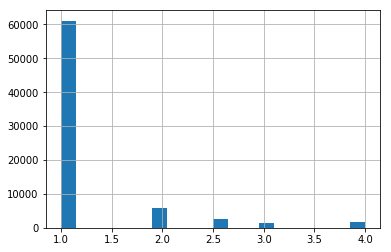

In [8]:
interactions_df.eventStrength.hist(bins=20)

Ремендательные системы подвержены проблеме холодного старта. В рамках данного задания предлагается работать только с теми пользователями, которые взаимодействовали хотя бы с 5 материалами.

Оставьте только таких пользователей. Их должно остаться 1140.

In [9]:
users_interactions_count_df = (
    interactions_df
    .groupby(['personId', 'contentId'])
    .first()
    .reset_index()
    .groupby('personId').size())
print('# users:', len(users_interactions_count_df))

users_with_enough_interactions_df = \
    users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('# users with at least 5 interactions:',len(users_with_enough_interactions_df))

# users: 1895
# users with at least 5 interactions: 1140


In [10]:
# users_interactions_count_df

Оставьте только те взаимодействия, которые касаются только отфильтрованных пользователей.

In [11]:
interactions_from_selected_users_df = \
    interactions_df.loc[
        np.in1d(
            interactions_df.personId,
            users_with_enough_interactions_df)]

In [12]:
print('# interactions before:', interactions_df.shape)
print('# interactions after:', interactions_from_selected_users_df.shape)

# interactions before: (72312, 9)
# interactions after: (69868, 9)


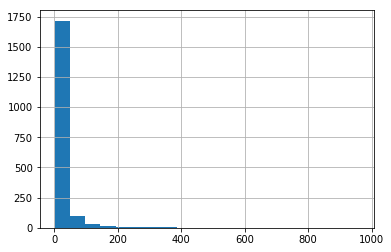

In [13]:
users_interactions_count_df.hist(bins=20)

В данной постановке каждый пользователей мог взаимодействовать с каждой статьёй более 1 раза (как минимум совершая различные действия). Предлагается "схлопнуть" все действия в одно взаимодействие с весом, равным сумме весов. 

Однако полученное число будет в том числе тем больше, чем больше действий произвёл человек. Чтобы уменьшить разброс предлагается взять логарифм от полученного числа (можно придумыват другие веса действиям и по-другому обрабатывать значения).

Также сохраним последнее значение времени взаимодействия для разделениея выборки на обучение и контроль.

In [14]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId']).eventStrength.sum()
    .apply(smooth_user_preference)
    .reset_index().set_index(['personId', 'contentId'])
)
interactions_full_df['last_timestamp'] = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId'])['timestamp'].last()
)
        
interactions_full_df = interactions_full_df.reset_index()
interactions_full_df.head(10)

,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.000000,1470395911
1,-1007001694607905623,-6623581327558800021,1.000000,1487240080
2,-1007001694607905623,-793729620925729327,1.000000,1472834892
3,-1007001694607905623,1469580151036142903,1.000000,1487240062
4,-1007001694607905623,7270966256391553686,1.584963,1485994324
5,-1007001694607905623,8729086959762650511,1.000000,1487240086
6,-1032019229384696495,-1006791494035379303,1.000000,1469129122
7,-1032019229384696495,-1039912738963181810,1.000000,1459376415
8,-1032019229384696495,-1081723567492738167,2.000000,1464054093
9,-1032019229384696495,-1111518890369033396,1.000000,1470109122


Разобьём выборку на обучение и контроль по времени.

In [15]:
split_ts = 1475519530
interactions_train_df = interactions_full_df.loc[interactions_full_df.last_timestamp < split_ts].copy()
interactions_test_df = interactions_full_df.loc[interactions_full_df.last_timestamp >= split_ts].copy()

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 29329
# interactions on Test set: 9777


Для удобства подсчёта качества запишем данные в формате, где строка соответствует пользователю, а столбцы будут истинными метками и предсказанями в виде списков.

In [16]:
interactions = (
    interactions_train_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={'contentId': 'true_train'})
    .set_index('personId')
)

interactions['true_test'] = (
    interactions_test_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
)

# заполнение пропусков пустыми списками
interactions.loc[pd.isnull(interactions.true_test), 'true_test'] = [
    list() for x in range(len(interactions.loc[pd.isnull(interactions.true_test), 'true_test']))]

interactions.head(1)

,true_train,true_test
personId,,
-1007001694607905623,"[-5065077552540450930, -793729620925729327]","[-6623581327558800021, 1469580151036142903, 72..."


## Часть 1: Baseline (модель по популярности)

Самой простой моделью рекомендаций (при этом достаточно сильной!) является модель, которая рекомендует наиболее популярные предметы. 

Предлагается реализовать её. Давайте считать, что рекомендуем мы по 10 материалов (такое ограничение на размер блока на сайте).

Посчитайте популярность каждой статьи, как сумму всех "оценок" взаимодействий с ней. Отсортируйте материалы по их популярности.

In [17]:
interactions_train_df.head()

,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.0,1470395911
2,-1007001694607905623,-793729620925729327,1.0,1472834892
6,-1032019229384696495,-1006791494035379303,1.0,1469129122
7,-1032019229384696495,-1039912738963181810,1.0,1459376415
8,-1032019229384696495,-1081723567492738167,2.0,1464054093


In [18]:
popular_content = (
    interactions_train_df
    .groupby('contentId')
    .eventStrength.sum().reset_index()
    .sort_values('eventStrength', ascending=False)
    .contentId.values
)

In [19]:
popular_content

array(['-6783772548752091658', '-133139342397538859',
       '-8208801367848627943', ..., '6240076106289531207',
       '6541551984368289722', '7083316110921342538'], dtype=object)

Теперь необходимо сделать предсказания для каждого пользователя. Не забывайте, что надо рекомендовать то, что пользователь ещё не читал (для этого нужно проверить, что материал не встречался в true_train).

In [20]:
top_k = 10

interactions['prediction_popular'] = (
    interactions.true_train
    .apply(
        lambda x:
        popular_content[~np.in1d(popular_content, x)][:top_k]
    )
)

Настало время оценить качество. Посчитайте precision@10 для каждого пользователя (доля угаданных рекомендаций). Усредните по всем пользователям. Везде далее будем считать эту же метрику.

(для каждого пользователя посчитаем долю правильно предсказанных статей (если в ответе их меньше 10ти, то будем нормировать на реальное количество статей)).

In [21]:
def calc_precision(column):
    return (
        interactions
        .apply(
            lambda row:
            len(set(row['true_test']).intersection(
                set(row[column]))) /
            min(len(row['true_test']) + 0.001, 10.0),
            axis=1)).mean()

In [22]:
calc_precision('prediction_popular')

0.006454207722621084

In [23]:
interactions.true_test.apply(len).sum()

9418

## Часть 2. Коллаборативная фильтрация.

Перейдём к более сложному механизму рекомендаций, а именно коллаборативной фильтрации. Суть коллаборативной фильтрации в том, что учитывается схожесть пользователей и товаров между собой, а не факторы, которые их описывают. 

__Предлагается на выбор реализовать один из двух подходов__: memory-based или модель со скрытыми переменные.

Для начала для удобства составим матрицу "оценок" пользователей. Нули будут обозначать отсутствие взаимодействия.

In [24]:
ratings = pd.pivot_table(
    interactions_train_df,
    values='eventStrength',
    index='personId',
    columns='contentId').fillna(0)

In [25]:
ratings.head()

contentId,-1006791494035379303,-1021685224930603833,-1022885988494278200,-1024046541613287684,-1033806831489252007,-1038011342017850,-1039912738963181810,-1046621686880462790,-1051830303851697653,-1055630159212837930,...,9217155070834564627,921770761777842242,9220445660318725468,9222265156747237864,943818026930898372,957332268361319692,966067567430037498,972258375127367383,980458131533897249,98528655405030624
personId,,,,,,,,,,,,,,,,,,,,,
-1007001694607905623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
-1032019229384696495,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,2.321928,0.0,0.0,0.0,0.0,0.0
-108842214936804958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,2.0,0.0,0.0,0.0
-1130272294246983140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0
-1160159014793528221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


### Memory-based

Посчитайте схожести пользователей с помощью корреляции Пирсона. Для каждой пары учитываем только ненулевые значения.

Для скорости работы лучше переходить от pandas к numpy.

In [25]:
ratings_m = ratings.as_matrix()

C:\Users\elena\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [125]:
similarity_users = np.zeros((len(ratings_m), len(ratings_m)))

for i in tqdm_notebook(range(len(ratings_m)-1)):
    for j in range(i+1, len(ratings_m)):
        
        # nonzero elements of two users
        mask_uv = (ratings_m[i] != 0) & (ratings_m[j] != 0)
        
        # continue if no intersection
        if np.sum(mask_uv) == 0:
            continue
            
        # get nonzero elements
        ratings_v = ratings_m[i, mask_uv]
        ratings_u = ratings_m[j, mask_uv]
        
        # normalization
        # ...
        ratings_v = ratings_v / np.linalg.norm(ratings_v)
        ratings_u = ratings_u / np.linalg.norm(ratings_u)
        
        # for nonzero std
        if len(np.unique(ratings_v)) < 2 or len(np.unique(ratings_u)) < 2:
            continue
        
        similarity_users[i,j] = np.corrcoef(ratings_u, ratings_v)[0][1]
        similarity_users[j,i] = similarity_users[i,j]

Теперь у нас есть матрицы схожести пользователей. Их можно использовать для рекомендаций.

Для каждого пользователя:

1. Найдём пользователей с похожестью больше $\alpha$ на нашего пользователя.
2. Посчитаем для каждой статьи долю пользователей (среди выделенных на первом шаге), которые взаимодействовали со статьёй.
3. Порекомендуем статьи с наибольшими долями со второго шага (среди тех, которые пользователь ещё не видел).

В нашем примере данных не очень много, поэтому возьмём $\alpha = 0$.

После того, как будут сделаны предсказания (новый столбец в interactions), посчитайте качество по той же метрике.

In [126]:
# your code
alpha = 0
Similarities = {}

for i in range(len(similarity_users)):
    Similarities[ratings.index[i]] = []
    for j in range(len(similarity_users)):
        if similarity_users[i,j] > alpha:
            Similarities[ratings.index[i]].append(ratings.index[j])
    Similarities[ratings.index[i]] = list(set(Similarities[ratings.index[i]]))

#interactions['prediction_user_based'] = # your code

Создадим словарь, в котором для каждого пользователя содержатся статьи, которые он смотрел.

In [127]:
from tqdm import tqdm

Viewed = {}

for user, row in ratings.iterrows(): 
    Viewed[user] = interactions.loc[user]['true_train']

In [80]:
Viewed[ratings.index[0]]

['-5065077552540450930', '-793729620925729327']

In [131]:
# ratings.index - users
# ratings.columns - articles

def get_popular(user, top_k=10):
    sim_users = ratings[ratings.index.isin(Similarities[user])] #оставляем в таблице только похожих
    sim_users = sim_users.drop(Viewed[user], axis=1) #убираем статьи, которые user уже смотрел
    return sim_users.astype(bool).sum(axis=0).sort_values(ascending=False).iloc[:top_k].index
    #считаем количество взаимодействий (=ненулевых элементов)

In [132]:
get_popular(ratings.index[0])

Index(['98528655405030624', '-6603351162010419903', '-6707474286910397949',
       '-6704596170548214779', '-6697357763177451167', '-668191656681035303',
       '-667193404227875686', '-6661204361884000663', '-6654470039478316910',
       '-6651333707067617642'],
      dtype='object', name='contentId')

In [133]:
t1 = time.time()
interactions['prediction_user_based1'] = ratings.index.map(get_popular)
t2 = time.time()
print(t2-t1)

4.358752250671387


In [128]:
import time

t1 = time.time()

prediction_user_based = []
for i in tqdm_notebook(range(len(similarity_users))):
        
    users_sim = similarity_users[i] > 0

    if sum(users_sim) == 0:
        prediction_user_based.append([])
    else:
        tmp_recommend = np.argsort(ratings_m[users_sim].sum(axis=0))[::-1]
        tmp_recommend = ratings.columns[tmp_recommend]
        recommend = np.array(tmp_recommend)[~np.in1d(tmp_recommend, interactions.iloc[i]['true_train'])][:10]
        prediction_user_based.append(list(recommend))

interactions['prediction_user_based2'] = prediction_user_based

t2 = time.time()

print(t2-t1)


6.723996877670288


In [134]:
calc_precision('prediction_user_based1'), calc_precision('prediction_user_based2')

(0.005328719267308723, 0.004558558709967571)

### Модель со скрытыми переменными

Реализуем подход с разложением матрицы оценок. Для этого сделайте сингулярное разложение (svd в scipy.linalg), на выходе вы получите три матрицы.

In [135]:
from scipy.linalg import svd

In [136]:
U, sigma, V = svd(ratings)

In [137]:
ratings.shape, U.shape, sigma.shape, V.shape

((1112, 2366), (1112, 1112), (1112,), (2366, 2366))

In [138]:
Sigma = np.zeros((1112, 2366))
Sigma[:1112, :1112] = np.diag(sigma)

In [139]:
new_ratings = U.dot(Sigma).dot(V)

In [140]:
sum(sum((new_ratings - ratings.values) ** 2))

8.4648772070354e-25

Значения у матрицы с сингулярными числами отсортированы по убыванию. Допустим мы хотим оставить только первые 100 компонент (и получить скрытые представления размерности 100). Для этого необходимо оставить 100 столбцов в матрице U, оставить из sigma только первые 100 значений (и сделать из них диагональную матрицу) и 100 столбцов в матрице V. Перемножьте преобразованные матрицы ($\hat{U}, \hat{sigma}, \hat{V^T}$), чтобы получить восстановленную матрицу оценок.

In [141]:
sigma[100:] = 0
Sigma = np.zeros((1112, 2366))
Sigma[:1112, :1112] = np.diag(sigma)

In [142]:
#U.dot(Sigma)[:, :100].shape, V[:100, :].T.shape

In [143]:
new_ratings = U.dot(Sigma).dot(V)

Посчитайте качество аппроксимации матрицы по норме Фробениуса (среднеквадратичную ошибку между всеми элементами соответствующими элементами двух матриц). Сравните его с простым бейзлайном с константным значением, равным среднему значению исходной матрицы. У аппроксимации ошибка должна получиться ниже.

In [144]:
sum(sum((new_ratings - ratings.values) ** 2))

constant_ratings = np.ones(ratings.shape)*np.mean(ratings.values)
sum(sum((constant_ratings - ratings.values) ** 2))

25843.42489891279

In [145]:
ratings.loc['-1257176162426022931', '-1022885988494278200']

2.700439718141092

In [146]:
new_ratings = pd.DataFrame(
    new_ratings, index=ratings.index, columns=ratings.columns)

In [147]:
new_ratings.loc['-1257176162426022931', '-1022885988494278200']

1.7796397556681205

Теперь можно делать предсказания по матрице. Сделайте их (не забывайте про то, что уже было просмотрено пользователем), оцените качество. Для этого необходимо для каждого пользователя найти предметы с наибольшими оценками в восстановленной матрице.

Чтобы сделать предсказание для пользователя (personId):
1. возьмите соответствующую ему строку в полученной таблице new_ratings
2. отсортируйте рейтинги по убыванию
3. затем возьмите индексы соответствующих столбцов (это и есть статьи) и преобразуйте их в массив

Добавьте в predictions top_k статей с наибольшими рейтингами, не забудьте выкинуть статьи, которые пользователь уже видел.

In [148]:
predictions = []

for personId in tqdm_notebook(interactions.index):
    prediction = (
        new_ratings
        .loc[personId]
        .sort_values(ascending=False)
        .index.values
    )
    
    predictions.append(
        list(prediction[~np.in1d(
            prediction,
            interactions.loc[personId, 'true_train'])])[:top_k])

In [149]:
interactions['prediction_svd'] = predictions

In [150]:
calc_precision('prediction_svd')

0.012212989310270754

До этих пор мы не проводили никаких преобразований с матрицей оценок. Отцентрируйте все ненулевые (!) значения по каждому пользователю. Сделайте предсказания, посчитайте качество.

In [93]:
#your code here

Продублируем функцию calc_precision с добавлением параметра interactions.

In [74]:
def calc_precision(interactions, column):
    return (
        interactions
        .apply(
            lambda row:
            len(set(row['true_test']).intersection(
                set(row[column]))) /
            min(len(row['true_test']) + 0.001, 10.0),
            axis=1)).mean()

Доля правильных предсказаний для пользователей с 10ю и более известными рекомендациями в test.

In [75]:
calc_precision(
    interactions.loc[interactions.true_test.apply(len) >= 10],
    'prediction_svd')

0.014566929133858273

In [76]:
calc_precision(
    interactions.loc[interactions.true_test.apply(len) >= 10],
    'prediction_popular')

0.0125984251968504

In [77]:
calc_precision(
    interactions.loc[interactions.true_test.apply(len) >= 10],
    'prediction_user_based')

0.0110236220472441

### Факторизационные машины (опционально)

Попробуем факторизационные машины из библиотеки pyFM (так как можно работать прямо из питона). https://github.com/coreylynch/pyFM

In [26]:
#from pyfm import pylibfm
from sklearn.feature_extraction import DictVectorizer

Перейдём к обобщению матричных разложений — факторизационным машинам, которые работают могут работать с контентной информацией. Вспомним, какие данные у нас изначально были:

В факторизационную машину можно загрузить "айдишники" пользователей и статей (то есть сделать аналог коллаборативной фильтрации) и одновременно различные признаки.

Удобно обрабатывать категориальные переменные (id и другие) можно с помощью DictVectorizer. Например, процесс может выглядить вот так:

In [27]:
# train = [
#     {"user": "1", "item": "5", "age": 19},
#     {"user": "2", "item": "43", "age": 33},
#     {"user": "3", "item": "20", "age": 55},
#     {"user": "4", "item": "10", "age": 20},
# ]
# v = DictVectorizer()
# X = v.fit_transform(train)
# y = np.repeat(1.0, X.shape[0])
# fm = pylibfm.FM()
# fm.fit(X,y)
# fm.predict(v.transform({"user": "1", "item": "10", "age": 24}))

Сгенерируйте таблицу с признаками в таком виде, где будут id пользователя, статьи и автора статьи и несколько признаков, которые вы сможете придумать. В качестве целевой переменной возьмите "силу" взаимодействия пользователя с каждой статьёй (помним, что у нас там все примеры по сути положительные). Запустите обучение модели на несколько итераций и сделайте предсказания. Какое качество удаётся достич? 

In [28]:
train_data = []

for i in tqdm_notebook(range(len(interactions_train_df))):
    features = {}
    features['personId'] = str(interactions_train_df.iloc[i].personId)
    features['contentId'] = str(interactions_train_df.iloc[i].contentId)
    
    try:
        article = articles_df.loc[features['contentId']]
        features['authorId'] = str(article.authorPersonId)
        features['authorCountry'] = str(article.authorCountry)
        features['lang'] = str(article.lang)
    except:
        features['authorId'] = 'unknown'
        features['authorCountry'] = 'unknown'
        features['lang'] = 'unknown'
    
    train_data.append(features)

Повторим эту процедуру для тестовой выборки. Заметим, что модель оценивает каждую пару потенциального взаимодействия, а значит, надо подготовить выборку из всех возможных пар из пользователей и статей.

In [32]:
from copy import deepcopy

test_data = []

for i in tqdm_notebook(range(len(interactions))):
    features = {}
    features['personId'] = str(interactions.index[i])  
    for j in range(len(ratings.columns)):
        features['contentId'] = str(ratings.columns[j])
        
        try:
            article = articles_df.loc[features['contentId']]
            
            features['title_length'] = len(article.title)
            features['text_length'] = len(article.text)
            
            features['authorId'] = str(article.authorPersonId)
            features['authorCountry'] = str(article.authorCountry)
            features['lang'] = str(article.lang)
        except:
            features['title_length'] = 0
            features['text_length'] = 0

            features['authorId'] = 'unknown'
            features['authorCountry'] = 'unknown'
            features['lang'] = 'unknown'

        test_data.append(deepcopy(features))

Векторизуем, получим разреженные матрицы.

In [176]:
dv = DictVectorizer()

train_features = dv.fit_transform(
    train_data + list(np.random.permutation(test_data)[:100000]))
test_features = dv.transform(test_data)

In [177]:
train_features

<129329x3481 sparse matrix of type '<class 'numpy.float64'>'
	with 646645 stored elements in Compressed Sparse Row format>

In [178]:
y_train = list(interactions_train_df.eventStrength.values) + list(np.zeros(100000))

In [179]:
train_features.shape, len(y_train)

((129329, 3481), 129329)

Укажем размер скрытого представления 10, сделаем 30 итераций.

In [ ]:
fm = pylibfm.FM(num_factors=10, num_iter=30, task='regression')
fm.fit(train_features, y_train)

Предскажем, оценим качество.

In [ ]:
test_features = dv.transform(test_data)
y_predict = fm.predict(test_features)

new_ratings = y_predict.reshape((1112, 2366))

In [ ]:
predictions = []

for i, person in enumerate(interactions.index):
    user_prediction = ratings.columns[np.argsort(new_ratings[i])[::-1]]
    predictions.append(
        user_prediction[~np.in1d(user_prediction,
                                 interactions.loc[person, 'true_train'])][:top_k])
    
interactions['fm_prediction'] = predictions

In [ ]:
calc_precision('fm_prediction')

Попробуйте добавить случайные негативные примеры из статей, с которыми пользователь не взаимодействовал. Какое качество удалось достичь?

In [ ]:
# your code

## Часть 3. Контентные  модели

В этой части реализуем альтернативный подход к рекомендательным системам — контентные модели.

Теперь мы будем оперировать не матрицей с оценками, а классической для машинного обучения матрицей объекты-признаки. Каждый объект будет характеризовать пару user-item и содержать признаки, описывающие как пользователя, так и товар. Кроме этого признаки могут описывать и саму пару целиком.

Матрица со всеми взаимодействиями уже получена нами на этапа разбиения выборки на 2 части. 

Придумаем и добавим признаков о пользователях и статьях. Сначала добавим информацию о статьях в данные о взаимодействиях.

In [78]:
interactions_train_df = interactions_train_df.merge(articles_df, how='left', on='contentId')
interactions_test_df = interactions_test_df.merge(articles_df, how='left', on='contentId')

In [79]:
# first feature index
features_start = len(interactions_train_df.columns)

После обучения модели нам придётся делать предсказания на тестовой выборке для всех возможных пар статья-пользователь. Подготовим такую матрицу, чтобы параллельно посчитать признаки для неё.

interactions - таблица (сделанная из interactions_train_df), где строка соответствует пользователю, а столбцы являются истинными метками и предсказанями в виде списков.

In [80]:
test_personId = np.repeat(interactions.index, len(articles_df)) 
test_contentId = list(articles_df.contentId) * len(interactions)

test = pd.DataFrame(
    np.array([test_personId, test_contentId]).T,
    columns=['personId', 'contentId'])
test = test.merge(articles_df, how='left', on='contentId')

test.head(1)

,personId,contentId,timestamp,eventType,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,-1007001694607905623,-4110354420726924665,1459193988,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en


Хотим добавить отрицательных примеров. Добавим случайные отсутствующие взаимодействия как отрицательные.

In [81]:
interactions_train_df = pd.concat((
    interactions_train_df,
    test.loc[
        np.random.permutation(test.index)[
            :1*len(interactions_train_df)]]), ignore_index=True)

interactions_train_df.eventStrength.fillna(0, inplace=True)

C:\Users\elena\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


Добавьте признаки-индикаторы возможных значений contentType.

In [83]:
articles_df.contentType.unique()

array(['HTML', 'RICH', 'VIDEO'], dtype=object)

In [84]:
interactions_train_df.shape

(58658, 16)

In [85]:
interactions_train_df['is_HTML'] = \
    interactions_train_df.contentType == 'HTML'
interactions_train_df['is_RICH'] = \
    interactions_train_df.contentType == 'RICH'
interactions_train_df['is_VIDEO'] = \
    interactions_train_df.contentType == 'VIDEO'

test['is_HTML'] = \
    test.contentType == 'HTML'
test['is_RICH'] = \
    test.contentType == 'RICH'
test['is_VIDEO'] = \
    test.contentType == 'VIDEO'

Добавьте признаки "длина названия" и "длина текста".

In [86]:
interactions_train_df['title_length'] = \
    interactions_train_df.title.fillna('').apply(len)
interactions_train_df['text_length'] = \
    interactions_train_df.text.fillna('').apply(len)

test['title_length'] = \
    test.title.fillna('').apply(len)
test['text_length'] = \
    test.text.fillna('').apply(len)

Добавьте признаки-индикаторы языка.

In [87]:
interactions_train_df.lang.value_counts()

en    40401
pt    18103
la       50
ja       43
es       34
Name: lang, dtype: int64

In [88]:
interactions_train_df['is_lang_en'] = \
    interactions_train_df.lang == 'en'
interactions_train_df['is_lang_pt'] = \
    interactions_train_df.lang == 'pt'

test['is_lang_en'] = \
    test.lang == 'en'
test['is_lang_pt'] = \
    test.lang == 'pt'

Дополнительные признаки

In [89]:
interactions_train_df['has_new'] = \
    interactions_train_df.title.fillna('').apply(lambda x: 'new' in x.lower())
interactions_train_df['has_why'] = \
    interactions_train_df.title.fillna('').apply(lambda x: 'why' in x.lower())
interactions_train_df['has_how'] = \
    interactions_train_df.title.fillna('').apply(lambda x: 'how' in x.lower())
interactions_train_df['has_ai'] = \
    interactions_train_df.title.fillna('').apply(lambda x: 'ai' in x.lower())

test['has_new'] = \
    test.title.fillna('').apply(lambda x: 'new' in x.lower())
test['has_why'] = \
    test.title.fillna('').apply(lambda x: 'why' in x.lower())
test['has_how'] = \
    test.title.fillna('').apply(lambda x: 'how' in x.lower())
test['has_ai'] = \
    test.title.fillna('').apply(lambda x: 'ai' in x.lower())

In [90]:
interactions_train_df['popularity'] = (
    interactions_train_df.contentId.map(
        interactions_train_df
        .groupby('contentId').eventStrength.sum()))

test['popularity'] = (
    test.contentId.map(
        interactions_train_df
        .groupby('contentId').eventStrength.sum()))

Обучим на полученных признаках градиентный бустинг.

In [91]:
import lightgbm 

regressor = lightgbm.LGBMClassifier()
regressor.fit(interactions_train_df[interactions_train_df.columns[features_start:]],
              interactions_train_df.eventStrength > 0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

Сделайте предсказания на тестовой выборке, сформируйте из них рекомендации. Оцените их качество.

In [92]:
predictions = regressor.predict_proba(test[test.columns[-12:]])[:, 1]

In [93]:
test['predictions'] = predictions

In [94]:
test[['personId', 'contentId', 'predictions']].head()

,personId,contentId,predictions
0,-1007001694607905623,-4110354420726924665,0.098399
1,-1007001694607905623,-7292285110016212249,0.096545
2,-1007001694607905623,-6151852268067518688,0.508044
3,-1007001694607905623,2448026894306402386,0.000022
4,-1007001694607905623,-2826566343807132236,0.105246


In [95]:
test = test.sort_values('predictions', ascending=False)

In [96]:
test[['personId', 'contentId', 'predictions']].head()

,personId,contentId,predictions
1138349,-6878112296616605612,8224860111193157980,0.961159
3161557,8420481937548705787,8224860111193157980,0.961159
3195074,8573995950821939440,8224860111193157980,0.961159
955529,-5868110530814399805,8224860111193157980,0.961159
440586,-3598766333334489248,8224860111193157980,0.961159


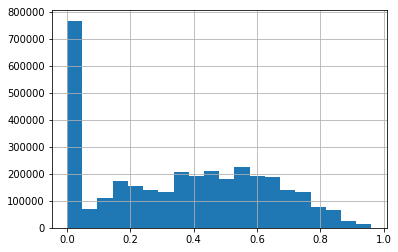

In [97]:
test.predictions.hist(bins=20)

In [98]:
predictions = test.groupby('personId')['contentId'].aggregate(list)

In [99]:
predictions.head()

personId
-1007001694607905623    [8224860111193157980, -6783772548752091658, -1...
-1032019229384696495    [8224860111193157980, -6783772548752091658, -1...
-108842214936804958     [8224860111193157980, -6783772548752091658, -1...
-1130272294246983140    [8224860111193157980, -6783772548752091658, -1...
-1160159014793528221    [8224860111193157980, -6783772548752091658, -1...
Name: contentId, dtype: object

In [100]:
tmp_predictions = []

for personId in tqdm_notebook(interactions.index):
    prediction = np.array(predictions.loc[personId])
    
    tmp_predictions.append(
        list(prediction[~np.in1d(
            prediction,
            interactions.loc[personId, 'true_train'])])[:top_k])

In [1]:
interactions['prediction_content'] = tmp_predictions

NameError: name 'tmp_predictions' is not defined

In [108]:
interactions['prediction_both'] = \
    interactions.apply(
        lambda row:
        list(row['prediction_content'][:5]) +
        list(row['prediction_user_based'][:5]), axis=1)

In [109]:
calc_precision(interactions, 'prediction_popular')

0.006454207722621084

In [112]:
calc_precision(interactions, 'prediction_user_based')

0.005328719267308723

In [113]:
calc_precision(interactions, 'prediction_content')

0.006657962814707724

In [114]:
calc_precision(interactions, 'prediction_both')

0.004183934799905191

In [115]:
calc_precision(interactions, 'prediction_svd')

0.012212989310270754

In [116]:
for c, imp in zip(interactions_train_df.columns, regressor.feature_importances_):
    print(c,imp)

authorCountry 12
authorPersonId 0
authorRegion 0
authorSessionId 850
authorUserAgent 887
contentId 68
contentType 14
eventStrength 26
eventType 9
lang 24
last_timestamp 42
personId 1068


Категориальные переменные с большим количеством значений можно закодировать с помощью mean-target кодирования. Закодируйте так id статьи и пользователя. Обучите новую модель и оцените качество.

In [ ]:
# your code